# Model Pipeline

Author: Jasmine Qin  
Date: 2020-05-25

In [1]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectFromModel

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.metrics import plot_confusion_matrix, f1_score, recall_score
from sklearn.metrics import classification_report

# Model Explanation
import eli5
import shap

/Users/jq/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jq/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Table of Contents
- [1. Load Data](#ld)
- [2. Summary](#s)
- [3. Feature Engineering](#fe)
- [4. Split Data](#sd)
- [5. Preprocessing](#pp)
- [6. Baseline Model](#bm)
- [7. Feature Importance and Selection](#fi)
- [8. Other Models](#om)
- [9. Hyperparameter Tuning](#ht)
- [10. Other Tests](#ot)

## 1. Load Data <a name="ld"></a>

- Run all scripts 01 to 04 to have the combined and cleaned data
- Load `combined_train.csv` and `combined_validate.csv`

In [27]:
train = pd.read_csv('../../data/processed/combined_train.csv',
                    low_memory=False).rename(columns={'Geo Local Area': 'LocalArea'})
validation = pd.read_csv('../../data/processed/combined_validate.csv',
                         low_memory=False).rename(columns={'Geo Local Area': 'LocalArea'})

## 2. Summary <a name="s"></a>

In [38]:
train.head(3)

,business_id,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,BusinessSubType,Unit,UnitType,House,Street,City,Province,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,label,Parking meters,Disability parking,Unemployment_rate
0,1,2018,3100450,18-516072,0.0,!Exotics BySIYTHE Corporation,NaN,Issued,2018-02-14,2018-12-31,Office,Design Company,170,Unit,422,RICHARDS ST,vancouver,BC,CA,V6B 2Z4,Downtown,1.0,189.0,2020-04-01 09:32:19+00:00,"{""type"": ""Point"", ""coordinates"": [-123.1119263...",0,19.0,3771.0,4.4
1,2,2004,804123,04-036444,0.0,.243 Racing Inc,NaN,Issued,2004-04-07,2004-12-31,Wholesale Dealer,NaN,NaN,NaN,1725,POWELL ST,vancouver,BC,CA,V5L 1H6,Grandview-Woodland,NaN,100.0,2019-07-21 13:48:32+00:00,"{""type"": ""Point"", ""coordinates"": [-123.0693914...",1,7.0,312.0,6.8
2,2,2005,884526,05-112560,0.0,.243 Racing Inc,NaN,Issued,2004-12-23,2005-12-31,Wholesale Dealer,NaN,NaN,NaN,1725,POWELL ST,vancouver,BC,CA,V5L 1H6,Grandview-Woodland,NaN,103.0,2019-07-21 13:48:35+00:00,"{""type"": ""Point"", ""coordinates"": [-123.0693914...",1,7.0,312.0,5.7


In [6]:
num_vars = ['NumberofEmployees', 'FeePaid', 'Parking meters', 'Disability parking', 'Unemployment_rate']
cat_vars = ['FOLDERYEAR', 'BusinessType', 'BusinessSubType', 'LocalArea']
label = ['label']

In [7]:
def describe_data(df, num_vars, cat_vars):
    print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.\n")
    
    num_summary = df[num_vars].describe()
    num_summary.loc['missing'] = [df[s].isnull().sum() for s in num_vars]
    
    cat_summary = {'cat_var':[], 'missing':[], 'unique':[]}
    for c in cat_vars:
        cat_summary['cat_var'].append(c)
        cat_summary['missing'].append(sum(df[c].isnull()))
        cat_summary['unique'].append(len(df[c].unique()))
    
    return num_summary, pd.DataFrame(cat_summary)

In [37]:
num_df, cat_df = describe_data(train, num_vars, cat_vars)
display(num_df, cat_df)

The dataset has 691687 rows and 29 columns.



,NumberofEmployees,FeePaid,Parking meters,Disability parking,Unemployment_rate
count,197304.000000,642604.000000,652178.000000,612158.000000,691687.000000
mean,14.822369,250.551315,9.870836,1340.267981,6.340626
std,1220.733151,754.829289,6.635367,1452.672150,1.432996
min,0.000000,-1624.000000,1.000000,7.000000,4.000000
25%,1.000000,91.000000,4.000000,91.000000,4.700000
50%,2.000000,121.000000,10.000000,898.000000,6.600000
75%,6.000000,166.000000,18.000000,1624.000000,7.400000
max,300813.000000,84706.000000,19.000000,3771.000000,8.800000
missing,494383.000000,49083.000000,39509.000000,79529.000000,0.000000


,cat_var,missing,unique
0,FOLDERYEAR,0,23
1,BusinessType,0,223
2,BusinessSubType,369211,404
3,LocalArea,14637,23


In [36]:
train['label'].value_counts()

1    566377
0    125310
Name: label, dtype: int64

In [10]:
# Correlation plot
#plt.figure(figsize=(12,10))
#sns.heatmap(train.corr(), annot=True, cmap=plt.cm.Blues)
#plt.show()

## 3. Feauture Engineering <a name="fe"></a>

- Including just cleaning for now, other steps to add in the future

In [39]:
def feature_engineering(df):
    df = df[df.LocalArea.notnull()]
    df = df[df.Status == 'Issued']
    
    df = df[num_vars+cat_vars+label]
    return df.drop(columns=label), df['label']

## 4. Split Data <a name="sd"></a>

- Using validation set as test for this model

In [33]:
X_train_valid, y_train_valid = feature_engineering(train)
X_test, y_test = feature_engineering(validation)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=2020)

## 5. Preprocessing <a name="pp"></a>

- include polynomial features (interactions, e.g., local area x business type)

In [41]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',
                              fill_value='missing')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('all', PolynomialFeatures(interaction_only=True, include_bias=False), np.arange(471))
    ])


## 6. Baseline Model <a name="bm"></a>

In [42]:
def evaluate_model(model, X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid):
    model.fit(X_train, y_train)
    print("Train Accuracy:", model.score(X_train, y_train))
    print("Validation Accuracy", model.score(X_valid, y_valid))
    print(classification_report(y_valid, model.predict(X_valid)))

    return plot_confusion_matrix(model, X_valid, y_valid,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues,
                                 values_format='d');


The max_iter was reached which means the coef_ did not converge


Train Accuracy: 0.5576612454049237
Validation Accuracy 0.5583987778387798
              precision    recall  f1-score   support

           0       0.19      0.65      0.29     17926
           1       0.90      0.54      0.68    107753

    accuracy                           0.56    125679
   macro avg       0.55      0.60      0.49    125679
weighted avg       0.80      0.56      0.62    125679



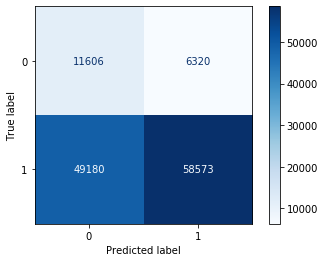

In [43]:
lr = LogisticRegression(solver='saga', class_weight='balanced')

lr_pip = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', lr)])

evaluate_model(lr_pip)

## 7. Feature Importance and Selection <a name="fi"></a>

- weights
- RFE
- L1, L2
- PCA
- `BusinessType` clean-up: topic modeling?

In [46]:
def explain_model(pip, df, verbose=True):
    pp1_features = num_vars+list(pip['preprocessor'].transformers_[1][1]['onehot'].get_feature_names())
    #pp2_features = list(pip['preprocessor2'].transformers_[0][1]['poly'].get_feature_names(input_features=pp1_features))
    #transformed_df = pd.DataFrame(
    #    pip["preprocessor2"].transform(pip["preprocessor"].transform(df)), columns=pp2_features)
    if verbose:
        return eli5.show_weights(pip['classifier'],
                                feature_names=pp1_features)
    else:
        return transformed_df


In [47]:
explain_model(lr_pip, X_train)

Weight?,Feature
+1.045,x1_Apartment House
+0.616,x2_Barrister & Solicitor
+0.595,x1_Multiple Dwelling
+0.579,x1_Secondary Suite - Permanent
+0.539,x1_Duplex
+0.452,x1_Health Services
+0.394,x2_Dentist
+0.325,x2_Physician/Surgeon
+0.316,x1_One-Family Dwelling
+0.269,x2_Bank


## 8. Other Models <a name="om"></a>

Train Accuracy: 0.5904454240201149
Validation Accuracy 0.5880536923431918
              precision    recall  f1-score   support

           0       0.21      0.66      0.31     17926
           1       0.91      0.58      0.71    107753

    accuracy                           0.59    125679
   macro avg       0.56      0.62      0.51    125679
weighted avg       0.81      0.59      0.65    125679



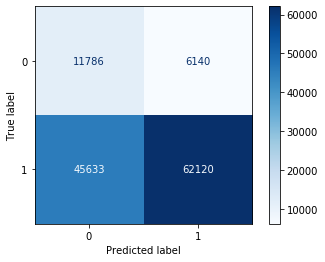

In [49]:
lgbm = LGBMClassifier(class_weight='balanced')

lgbm_pip = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgbm)])

evaluate_model(lgbm_pip)

In [50]:
explain_model(lgbm_pip, X_train)

Weight,Feature
0.1565,x1_Apartment House
0.1543,FeePaid
0.0848,NumberofEmployees
0.0470,Unemployment_rate
0.0421,x2_Barrister & Solicitor
0.0400,x1_Health Services
0.0391,x1_Multiple Dwelling
0.0231,x1_Duplex
0.0183,x1_Secondary Suite - Permanent
0.0177,x2_missing


## 9. Hyperparameter Tuning <a name="ht"></a>

- regularization strength
- tree max depth
- sampling strategy for SMOTE
- missing value imputing strategy
- degree of polynomial terms

In [24]:
lrhp = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LGBMClassifier(class_weight='balanced'))])

param_grid = {
    'classifier__reg_lambda': [0.1, 1],
}

gs = GridSearchCV(lrhp, param_grid, cv=5, scoring='f1')
gs.fit(X_train, y_train);

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

## 10. Other Tests <a name="ot"></a>

- SMOTE

Train Accuracy: 0.7795397762536005
Validation Accuracy 0.7763190350018698
              precision    recall  f1-score   support

           0       0.24      0.26      0.25     17926
           1       0.87      0.86      0.87    107753

    accuracy                           0.78    125679
   macro avg       0.56      0.56      0.56    125679
weighted avg       0.78      0.78      0.78    125679



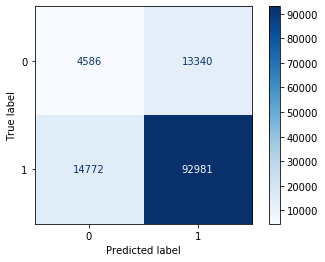

In [51]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
smote_pip = Pipeline(steps=[('preprocessor', preprocessor),
                            ('smote', SMOTE(sampling_strategy=0.85)),
                            ('classifier', lgbm)])

param_grid = {
    'smote__sampling_strategy': [0.1, 0.5, 0.8, 1.0],
}

#gs = GridSearchCV(smote_pip, param_grid, cv=5, scoring='f1')
#gs.fit(X_train_valid, y_train_valid)
evaluate_model(smote_pip)